### Proving Theorems In Propositional Logic with LSTM-Based Text Generators
#### Author: Omar Afifi

Consider a number of propositional (i.e. variable-free) sentences (premsises). For example: 

1. p→q 
2. o
3. pv¬o

A propositional proof from the premises to a conclusion (another sentence) is a sequence of variable-free statements that follow from the premises by logical deduction rules (e.g. modus ponens, modus tollens, modus tollendo ponens, dysjuntive elimination, etc ... )

For example, a proof of the propositional sentence (q) from the preceding premises is as follows: 

4. ¬¬o (from 2, double negation)
5. p (from 3 and 4, dysjuntive elimination )
5. q (from 1 and 5, modus ponens)

QED.


This notebook explores the utility of using LSTM text-generators to generate a propositional proof given a collection of propositional sentences. Our hope is that it can be helpful as a stepping stone to making progress in the arena of stochastic theorem provers. 

Credits: Hugging Face User ergotts for building this dataset: https://huggingface.co/datasets/ergotts/propositional-logic


### Loading Data and preparing the input

In [1]:
import process_data

#load the data from hugging face mode = 'w' means that we are tokenizing words rather than characters or sentences. 
proofs_dataset = process_data.LoadLogicData(mode = 'w') 

#format the proofs: essentially just mapping words to integers and then creating n-gram sequences
word_to_int, int_to_word, sequenced_proofs = process_data.generate_sequences(proofs_dataset)

#split data into input and label by setting label equal to next word.
#sequence length is the length of eqch sequence, this allows us to pack them during training. 
X, sequence_lengths,y = process_data.makeXy(sequenced_proofs)

X_train, X_val, train_lengths, val_lengths, y_train, y_val = process_data.makeSplit(X,sequence_lengths, y, .80)

/Users/omarafifi/Downloads/LSTM-Prover/Automated-Theorem-Proving-With-LSTM-Networks/ls_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Making the Data Compatible With Torch API

In [2]:
import torch as t
import torch.utils.data  as data

#train data
X_train = t.tensor(X_train, dtype = t.int64)
train_lengths =  t.tensor(train_lengths, dtype = t.int64)
y_train = t.tensor(y_train, dtype = t.int64)

train_loader = data.DataLoader(data.TensorDataset(X_train,train_lengths, y_train),
                            batch_size = 100) #model expects training data to be batched a dataLoader

#validation data
X_val = t.tensor(X_val, dtype = t.int64)
val_lengths =  t.tensor(val_lengths, dtype = t.int64)
y_val = t.tensor(y_val, dtype = t.int64)

validation_data = (X_val, val_lengths, y_val) # this model will expect validation data to be a tuple


### Loading the Model and Training
Note: This model does not suport GPU processing. It only takes ~10 minutes to run on a M1 CPU. 

If you want to make it GPU proccessable, then you need to edit model.py and write the tensors to the GPU as appropriate

In [3]:
#set Your params as desired here
import model
import torch

vocab_size = len(word_to_int)
hidden_size = 6
num_layers = 2
epochs = 8
loss_function = torch.nn.CrossEntropyLoss(reduction = "mean")
seq_length = len(X[0])

In [4]:

lstm = model.LSTM(seq_length = seq_length, 
            hidden_size = hidden_size, 
            num_layers = num_layers, 
            vocab_size = vocab_size)

optimizer = torch.optim.Adam(params = lstm.parameters(), lr = .01)
training_accuracies, training_losses, validation_accuracies, validation_losses = lstm.Train(train_loader, 
                                                                                            epochs, 
                                                                                            loss_function, 
                                                                                            optimizer, 
                                                                                            validation_data)

Epoch [1/8], Training Loss: 3.6632
Epoch [1/8], Training Accuracy: 0.0745
Epoch [1/8], Validation Loss: 3.5399
Epoch [1/8], Validation Accuracy: 0.0567
   
Epoch [2/8], Training Loss: 3.4953
Epoch [2/8], Training Accuracy: 0.0879
Epoch [2/8], Validation Loss: 3.5271
Epoch [2/8], Validation Accuracy: 0.0900
   
Epoch [3/8], Training Loss: 3.4752
Epoch [3/8], Training Accuracy: 0.1038
Epoch [3/8], Validation Loss: 3.5067
Epoch [3/8], Validation Accuracy: 0.0951
   
Epoch [4/8], Training Loss: 3.4380
Epoch [4/8], Training Accuracy: 0.1036
Epoch [4/8], Validation Loss: 3.4792
Epoch [4/8], Validation Accuracy: 0.0932
   
Epoch [5/8], Training Loss: 3.4060
Epoch [5/8], Training Accuracy: 0.1056
Epoch [5/8], Validation Loss: 3.4564
Epoch [5/8], Validation Accuracy: 0.1051
   
Epoch [6/8], Training Loss: 3.3759
Epoch [6/8], Training Accuracy: 0.1216
Epoch [6/8], Validation Loss: 3.4308
Epoch [6/8], Validation Accuracy: 0.1165
   
Epoch [7/8], Training Loss: 3.3524
Epoch [7/8], Training Accurac

In [5]:
lstm.parameters

<bound method Module.parameters of LSTM(
  (embedding): Embedding(69, 6)
  (lstm): LSTM(6, 6, num_layers=2, batch_first=True, dropout=1.0)
  (fc): Linear(in_features=6, out_features=69, bias=True)
)>

### Performance Visualizations

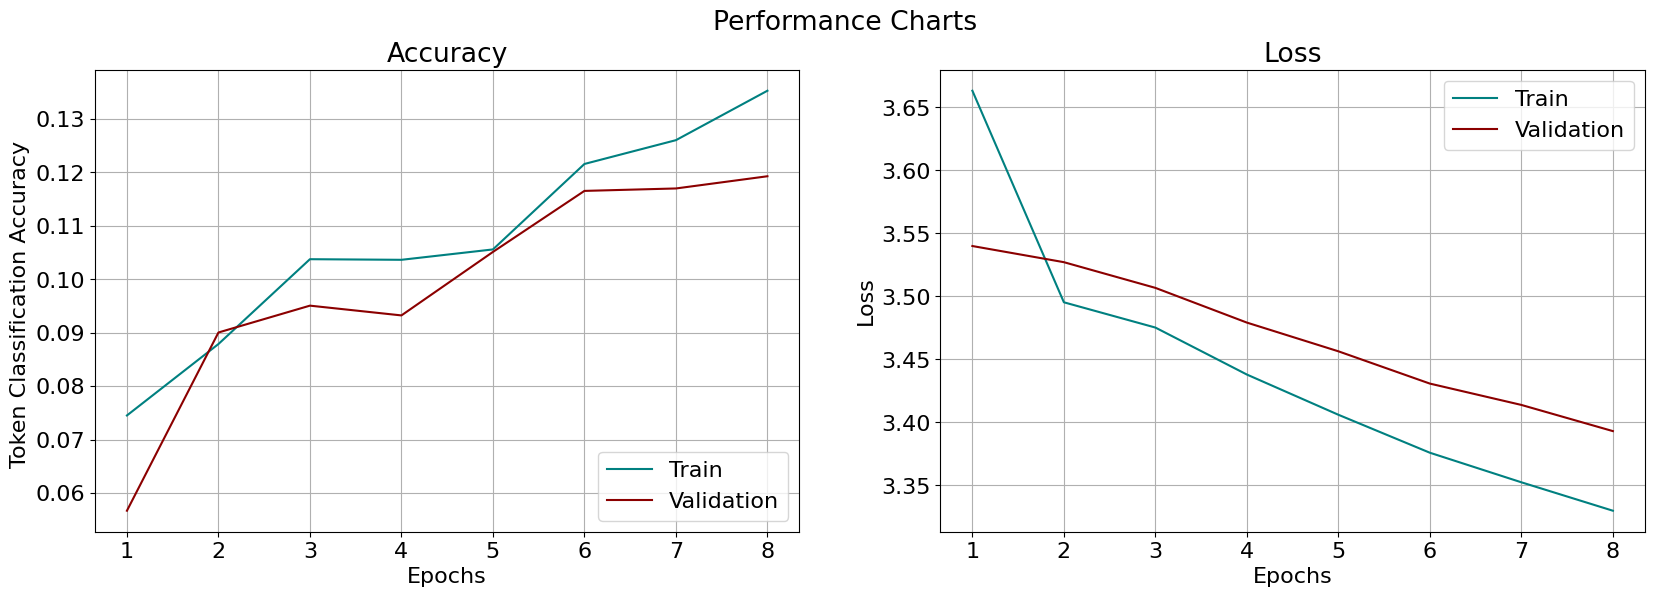

In [6]:
import matplotlib.pyplot as plt
import evaluate

fig, axs = evaluate.plotResults(epochs, training_accuracies, 
                                validation_accuracies, 
                                training_losses, validation_losses)
plt.show()

### Asking the Model to Generate a Proof From Premises

In [7]:
#loads some unseen premises from hugging face

test_data = process_data.load_test_data()
test_sequence_lengths, test_data = process_data.process_test_data(test_data, word_to_int)
test_data = process_data.pad(test_data, 0, seq_length)

#If you want to save the proofs to your folder, you can specify a path and set save = true in generate_proofs
#generated proofs returns a list of coleted proofs, it will also print the first value as a sample

path = ""
generated_proofs = evaluate.generate_proofs(lstm, test_data, test_sequence_lengths, int_to_word, save = True, path = path)



Sample Output
 
originalpremisea→boriginalpremisea→→→→stepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstepstep


### See How More Data and Larger Models Improve Performance

In [ ]:
%run growth.py